# MNiST DATA SET
This notebook uses the MNIST handwritten dataset to practice 2-dimension convolutional neural networks

In [3]:
%matplotlib notebook
import numpy as np
np.random.seed(123)
from matplotlib import pyplot as plt

import keras
print(f"keras version: {keras.__version__}")
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

config = tf.ConfigProto()

# Tensorflow automatically takes up a majority of memory when running the neural network
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

import os

import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
from sklearn import metrics

from time import time

Using TensorFlow backend.


keras version: 2.2.4
tensorflow version: 1.12.0
scikit-learn version: 0.20.2


# Widget Based Progress Bar For Jupyter Notebooks

In [4]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Load MNIST Dataset <a class="anchor" id="load"></a>

In this example we will use the MNIST dataset from keras. This dataset is nx28x28 in size, and is already split into training and testing data

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training data shape")
print(X_train.shape)
print("Testing data shape")
print(X_test.shape)
print((np.nanmin(X_train), np.nanmax(X_train)))

Training data shape
(60000, 28, 28)
Testing data shape
(10000, 28, 28)
(0, 255)


# Preprocess the data <a class="anchor" id="preprocess"></a>

Before we can start to build and train our neural network, we first need to preprocess the data so that the keras framework can understand and interpret it

## Reshape and normalize image data <a class="anchor" id="reshape"></a>

"Typical" image data is RGB and would have a shape Nx28x28x3. This data is greyscale, so the shape needs to be Nx28x28x1. Our data is only Nx28x28, so we need to add an additional dimension for Keras to appropriately handle

We will alsoconvert to float32 and normalize the inputs to [0,1]. While this isn't strictly necessary, normalizing input data tends to improve performance

In [6]:
# reshape the data
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
# cast to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize inputs
X_train /= 255
X_test /= 255

## Process the labels <a class="anchor" id="labels"></a>

As provided, the labels are directly associated with the data, i.e.

`y_train[9] = 4 # the 10th data point is an image of a "4"`

Because the output of our neural network will be 10 neurons, each associated with a digit, we need the labels to be categorized: rather than `y_train[9] = 4`, we need `y_train[9] = [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`

We use `np_utils.to_categorical` to achieve this

In [7]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [8]:
#garbage collector
import gc
# del model
K.clear_session()
gc.collect()

12

# Visualizing the Neural Network layers

Artificial neural networks are often referred to as "black boxes" because the weighting and outputs of the layers are not easy to view (and as we will see, are not necessarily easy to inuit/interpret when we can).

Here we create another neural net, this time with 3 convolutional layers before a maxpooling layer. We will then view the output of each layer after training when supplied with an image.

In [9]:
if os.path.exists("VizModel.h5"):
    model = keras.models.load_model("VizModel.h5")
else:

    model = Sequential()

    model.add(Convolution2D(32, (5, 5), activation='relu', padding="Same",
                            input_shape=(28, 28, 1), name="Conv1D_1"))
    convout1 = Activation('relu', name="Act1")
    model.add(convout1)

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Convolution2D(64, (5, 5), activation='relu', padding="Same", name="Conv1D_4"))
    convout4 = Activation('relu', name="Act4")
    model.add(convout4)


    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Convolution2D(128, (5, 5), activation='relu', padding="Same", name="Conv1D_9"))
    convout9 = Activation('relu', name="Act9")
    model.add(convout9)

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Dropout(0.25))
    maxout = Activation('relu')
    model.add(maxout)

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1)
    tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=(X_test, y_test),
              callbacks=[early_stop, tensorboard])

    print(model.summary())
    score = model.evaluate(X_test, y_test)
    print(score)

    y_pred = model.predict(X_test)
    
    #Printing the confusion matrix will give us a better visualization on what numbers the model 
    #is incorrectly guessing, and what numbers it is guessing instead

    cm = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Classification report for classifier %s:\n%s\n"
          % (model, metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))
    print("Confusion matrix:\n%s" % cm)
    
    

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 80us/step - loss: 0.4593 - acc: 0.8523 - val_loss: 0.0724 - val_acc: 0.9763
Epoch 2/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.1002 - acc: 0.9703 - val_loss: 0.0471 - val_acc: 0.9836
Epoch 3/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0666 - acc: 0.9800 - val_loss: 0.0271 - val_acc: 0.9903
Epoch 4/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.0556 - acc: 0.9839 - val_loss: 0.0317 - val_acc: 0.9901
Epoch 5/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.0398 - acc: 0.9887 - val_loss: 0.0238 - val_acc: 0.9919
Epoch 6/100
60000/60000 [==============================] - 3s 55us/step - loss: 0.0367 - acc: 0.9890 - val_loss: 0.0204 - val_acc: 0.9934
Epoch 7/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0292 - acc: 0.9908 - val_loss: 0.0182 - 

In [10]:
if not os.path.exists("VizModel.h5"):
    model.save("VizModel.h5")

# Visualize the kernels

Images of the convolutions that transform the input image.

<IPython.core.display.Javascript object>


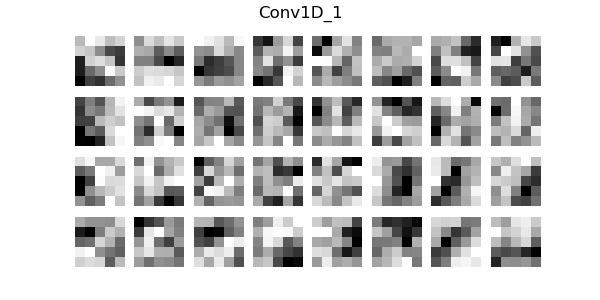

<IPython.core.display.Javascript object>


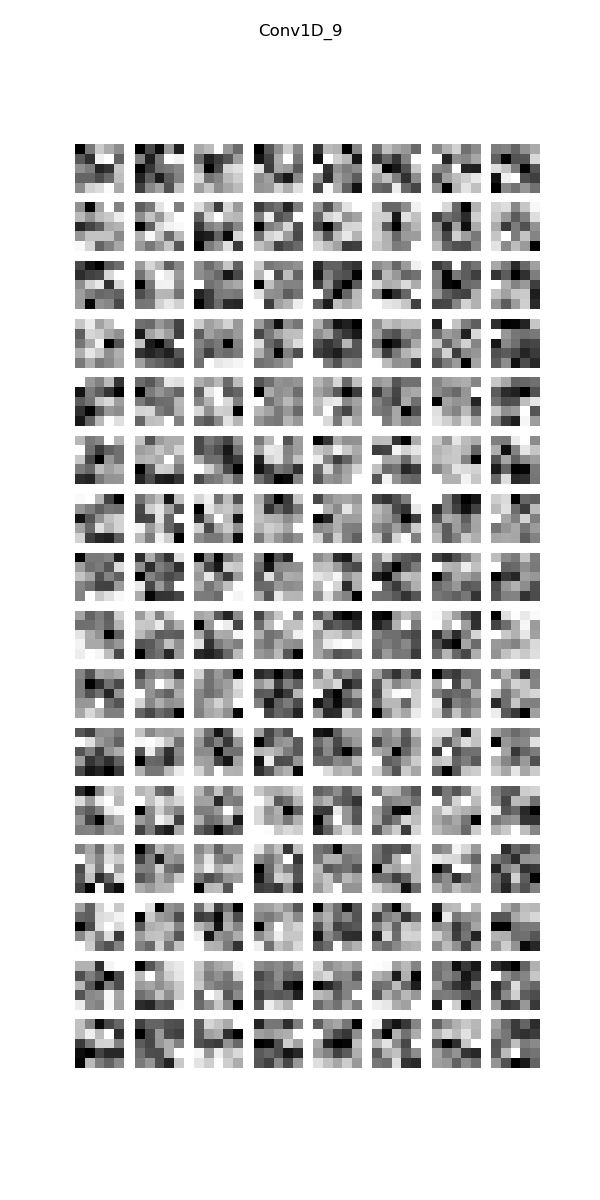

In [12]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# layers_to_visualize = ["Conv1D_1", "Conv1D_2", "Conv1D_3",
#                        "Conv1D_4", "Conv1D_5", "Conv1D_6",
#                        "Conv1D_7", "Conv1D_8", "Conv1D_9"]
layers_to_visualize = ["Conv1D_1", "Conv1D_9"]

inputs = [K.learning_phase()] + model.inputs


for layer_name in layers_to_visualize:
    l_layer = layer_dict[layer_name]
#     l_inputs = [K.learning_phase()] + model.inputs
    l_weights = l_layer.get_weights()[0][:,:,0,:]
    col_size = 8
    row_size = l_weights.shape[2] // col_size
    fig_width = 6
    fig, ax = plt.subplots(row_size, col_size, figsize=(fig_width,fig_width/col_size*row_size))
    filter_index = 0
    for row in range(0,row_size): 
        for col in range(0,col_size):
            ax[row][col].imshow(l_weights[:,:,filter_index], cmap="gray")
            ax[row][col].axis("off")
            filter_index += 1
#     plt.subplots_adjust(wspace=0.02)
    fig.suptitle(layer_name)
    plt.show()

For this scenario, these are not very advantageous to analyze

# View the transformed images

<IPython.core.display.Javascript object>


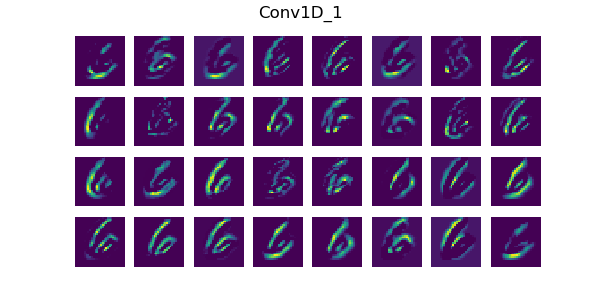

<IPython.core.display.Javascript object>


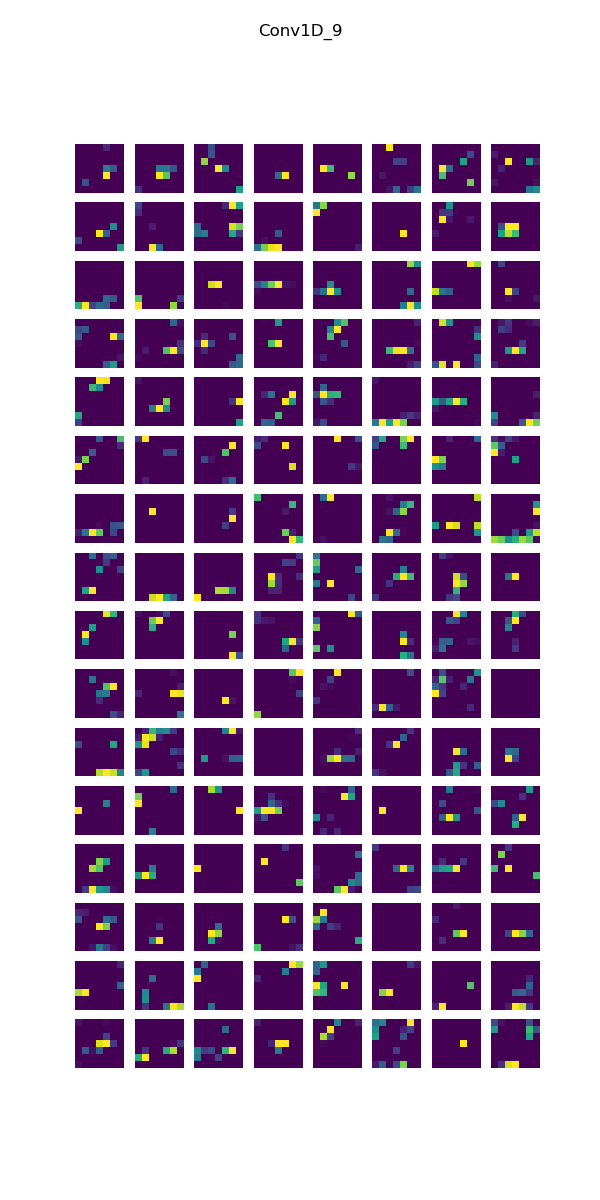

In [11]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

layers_to_visualize = ["Conv1D_1", "Conv1D_9"]
img_to_visualize = np.expand_dims(X_train[13], axis=0)
    
for layer_name in layers_to_visualize:
    l_layer = layer_dict[layer_name]
    l_inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [l_layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    # compute the convolutional output of the layer given
    # the input image
    # e.g. The first layer will take a 28x28 image and will use
    # a Convolution2D layer to pass a 3x3 kernel to create 32 filters
    # meaning 1 28x28x1 image becomes 32 26x26x1 images
    convolutions = convout1_f(img_to_visualize)
    # use the squeeze function dump the channel data
    convolutions = np.squeeze(convolutions)
        
    col_size = 8
    row_size = convolutions.shape[2] // col_size
    fig_width = 6
    fig, ax = plt.subplots(row_size, col_size, figsize=(fig_width,fig_width/col_size*row_size))
    filter_index = 0
    for row in range(0,row_size): 
        for col in range(0,col_size):
            ax[row][col].imshow(convolutions[:,:,filter_index])
            ax[row][col].axis("off")
            filter_index += 1
    fig.suptitle(layer_name)
    plt.show()

We can also visualize the activations for a particular layer?

# Visualizing the "activations"

In [13]:
import gc
del model
K.clear_session()
gc.collect()
if os.path.exists("VizModel.h5"):
    model = keras.models.load_model("VizModel.h5")

In [14]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from vis.input_modifiers import Jitter
from vis.visualization import get_num_filters

In [15]:
print(model.layers[-1].activation)
layer_idx = utils.find_layer_idx(model, layer_name)
print(model.layers[layer_idx])

<function softmax at 0x7f0241cc18c8>


(127, 259, 1)


<IPython.core.display.Javascript object>


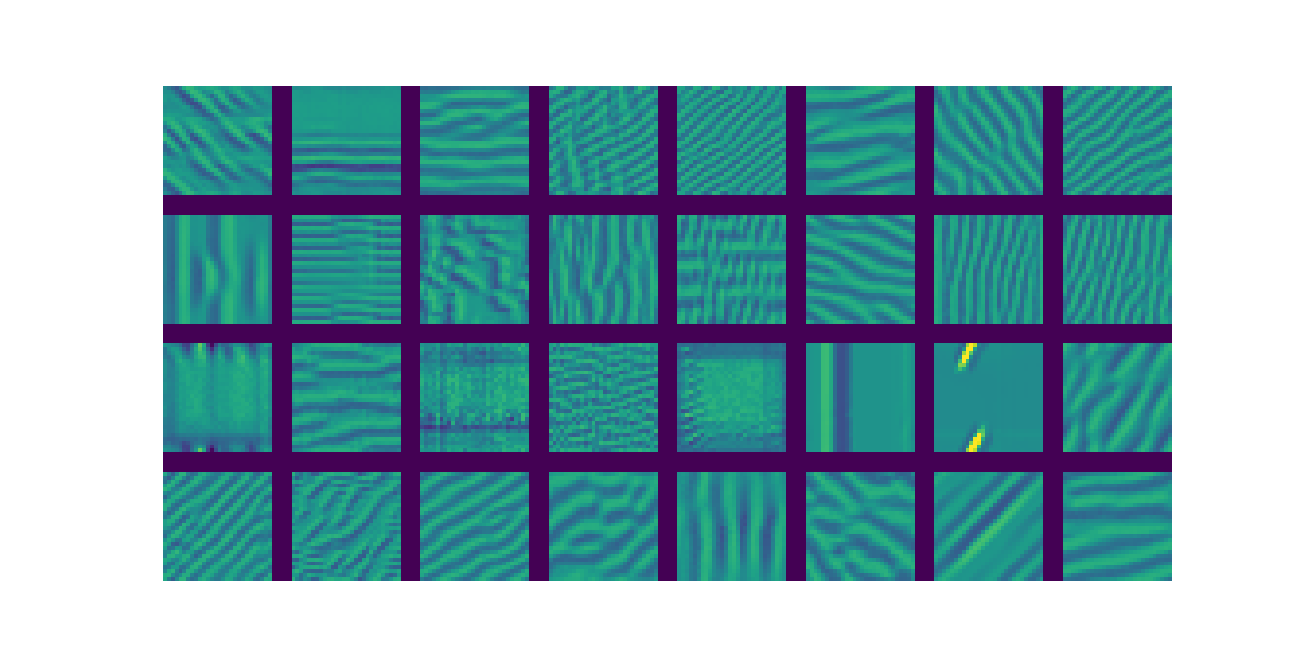

In [16]:
# model.layers[-1].activation = activations.linear
# model = utils.apply_modifications(model)

layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = "Conv1D_1"
layer_idx = utils.find_layer_idx(model, layer_name)
num_filters = get_num_filters(model.layers[layer_idx])
filters = np.arange(num_filters)
col_size = 8
row_size = num_filters // col_size
fig_width = 18
vis_images = list()
for idx in log_progress(filters):
    row = idx // col_size
    col = idx % col_size
    img = visualize_activation(model, layer_idx=layer_idx, filter_indices=idx,
                               tv_weight=0.0, input_modifiers=[Jitter(0.05)])
#     img = utils.draw_text(img, "Filter {}".format(idx))
    vis_images.append(img)
stitched = utils.stitch_images(vis_images, cols=8)
print(stitched.shape)
plt.figure()
plt.axis("off")
plt.imshow(stitched[:,:,0], interpolation="None")
plt.show()

In [20]:
print(vis_images[0][0][0])
print(img.shape)

[134]
(28, 28, 1)


<IPython.core.display.Javascript object>


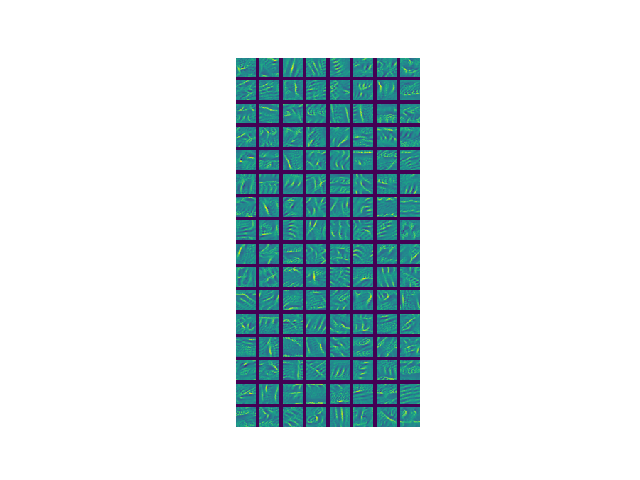

In [18]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

layer_name = "Conv1D_9"
layer_idx = utils.find_layer_idx(model, layer_name)
num_filters = get_num_filters(model.layers[layer_idx])
filters = np.arange(num_filters)
col_size = 8
row_size = num_filters // col_size
fig_width = 18
vis_images = list()
for idx in log_progress(filters):
    row = idx // col_size
    col = idx % col_size
    img = visualize_activation(model, layer_idx=layer_idx, filter_indices=idx,
                               tv_weight=0.0, input_modifiers=[Jitter(0.05)])
#     img = utils.draw_text(img, "Filter {}".format(idx))
    vis_images.append(img)
stitched = utils.stitch_images(vis_images, cols=8)

plt.figure()
plt.axis("off")
plt.imshow(stitched[:,:,0], interpolation="None")
plt.show()

<IPython.core.display.Javascript object>


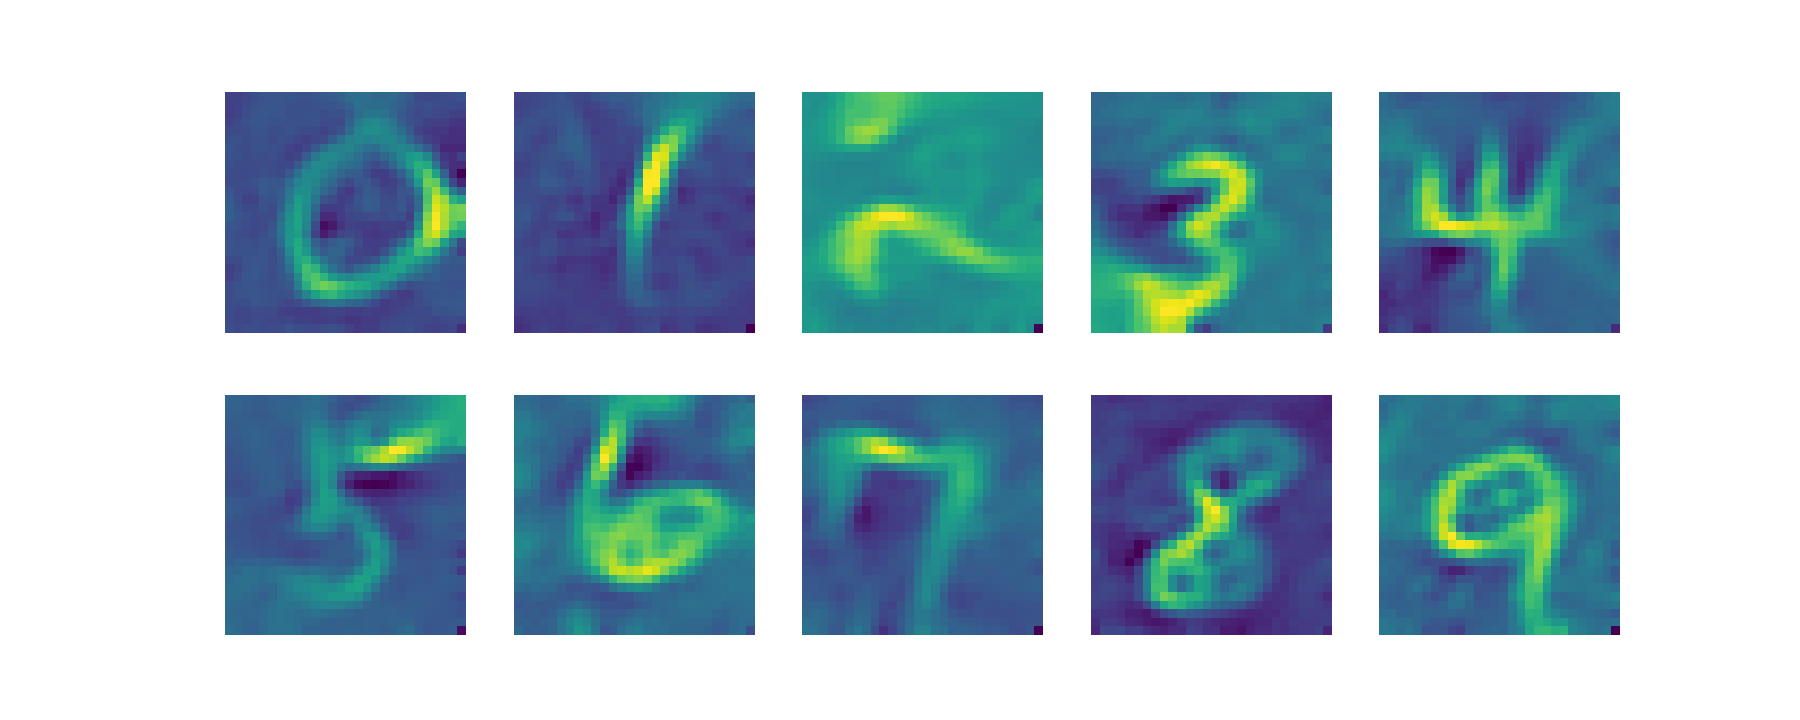

In [17]:
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

row_size=2
col_size=5
fig_width=18
fig, ax = plt.subplots(row_size, col_size, figsize=(fig_width,fig_width/col_size*row_size))
vis_imgs = list()
for img_idx in log_progress(range(10)):
    img = visualize_activation(model, layer_idx=-1, filter_indices=img_idx, input_range=(0., 1.),
                               tv_weight=0., input_modifiers=[Jitter(0.05)])
    vis_imgs.append(img)
for img_idx in log_progress(range(10)):
    img = visualize_activation(model, layer_idx=-1, filter_indices=img_idx, input_range=(0., 1.),
                               seed_input=vis_imgs[img_idx])
    row = img_idx // 5
    col = img_idx % 5
    ax[row][col].imshow(img.reshape(28,28))
    ax[row][col].axis("off")

plt.show()

In [ ]:
# The current model is at 99% accuracy 
# The visualizations of each layer allow us to understand in greater detail what the machine has learned
#T